# Trabajo práctico integrador: Computer Vision II

Especialización en IA - FIUBA
4to bimestre 2022

Integrantes:
* Anahi Bazet
* Lionel Gutierrez 


## Objetivo

Dada una imagen de una habitación de una vivienda se determina si se trata de un baño, un dormitorio, un comedor, una cocina o un living.
Es un problema de clasificación multi-clase de 5 clases.

Para poder resolverlo, se aplican diferentes tipos de redes neuronales de clasificación (VGG19, ResNet50, Inception V3 y AlexNet) con trasfer-learning (feature extraction) y data augmentation: rotación, color jitter (matiz, contraste y brillo) y desenfoque gaussiano. Luego, se comparan resultados y se extraen conclusiones.

Por otro lado, para el caso particular de AlexNet, se evalúa la performance de la red combinando las transformaciones de data augmentation aplicadas (rotación, color jitter y desenfoque gaussiano) hasta que no queda ninguna. También se aplica una estrategia de escala de grises para comparar con la de color jitter. Por último, se utiliza AutoAugment. En este caso, también se comparan resultados y se extraen conclusiones.

Otra cuestión que se analiza, es lo que sucede si no se aplica transfer learning a Alexnet, es decir, si se entrenan todos sus pesos. En este caso se aplica con y sin data augmentation, lo que podemos encontrar en la otra notebook "TP final CV2- 5Cohorte CEIA- Habitaciones-Modelo-sin-transfer-learning". También se comparan esos resultados, con los obtenidos en esta notebook para AlexNet con transfer learning (con y sin data augmentation). 



## Importación de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import cv2
import torch
import copy
import torchvision
import torchsummary
import torch.nn as nn
from PIL import Image, ImageEnhance, ImageOps
import random

!pip install torchmetrics
import torchmetrics
import matplotlib.image as mpimg

from torch.utils.data import DataLoader, random_split

#Modelos 
from torchvision.models.vgg import VGG19_Weights
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.inception import Inception_V3_Weights
from torchvision.models.resnet import ResNet50_Weights
import torchvision.models as modelos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.1 MB/s 


## Importación del dataset

El dataset es el siguiente: https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset

In [2]:
# https://drive.google.com/file/d/1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh/view?usp=sharing
!gdown --id 1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh
To: /content/Habitaciones.zip
100% 122M/122M [00:00<00:00, 176MB/s]


In [3]:
# Se descomprime el dataset.
!unzip   /content/Habitaciones.zip > /dev/null

In [4]:
# Se guarda la ruta base en una variable.
path_base = '/content/House_Room_Dataset'

## Conección a google drive para guardar los modelos ejecutados

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploración del dataset

In [6]:
# Si bien las imagenes están en tamaño 224 * 224, se aplica igualmente la 
# transformación para llevarlas a ese tamaño. Esto pensando que a futuro
# se podrían incorporar imágenes de otros tamaños.
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224, 224))
                  ])

set = torchvision.datasets.ImageFolder(root=path_base, transform=data_transforms)

In [7]:
# Cantidad de clases del set de datos y cantidad de datos del mismo.
cantidad_clases = len(set.classes) 
longitud_set = len(set)
print("Cantidad de imagenes del dataset: ",longitud_set)
print("Cantidad de clases del dataset: ",cantidad_clases)

Cantidad de imagenes del dataset:  5250
Cantidad de clases del dataset:  5


In [8]:
print("Las clases del dataset son: ",set.classes)

Las clases del dataset son:  ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']


In [9]:
# Conformación del set de datos.
(img, class_img) = set[0]
print (type(img))
print (class_img)

<class 'PIL.Image.Image'>
0


In [10]:
# Por cada imagen: la ruta y la clase a la que pertenece.
set.imgs[0]

('/content/House_Room_Dataset/Bathroom/bath_1.jpg', 0)

(224, 224, 3)


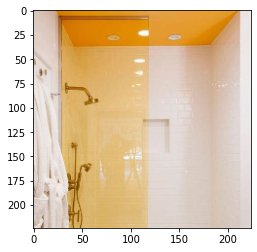

In [11]:
# Se muestra una imagen.
# image = mpimg.imread(path_base+"/Bathroom/bath_2.jpg")
image= mpimg.imread(set.imgs[0][0])

print(image.shape)
plt.imshow(image)
plt.show()

## Split en entrenamiento, validación y pruebas

In [12]:
valid_size = 0.1
test_size = 0.1
n_val = int(np.floor(valid_size * longitud_set))
n_test = int(np.floor(test_size * longitud_set))
n_train = longitud_set - n_val - n_test

train_ds_original, val_ds_original, test_ds_original = random_split(set, [n_train, n_val, n_test])

## Transformaciones: data augmentation

In [13]:
# Solo la conversión a tensor.
transform_to_tensor = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                      ])

In [14]:
# Data augmentation sobre rotación, color (brillo, contraste y matiz) y desenfoque gaussiano.
# Se aplica de forma aleatoria con una probabilidad.
# Conversión a tensor.
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomRotation(degrees=180)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05, hue=0.05)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

In [15]:
# Se realizan copias de los dataset originales.
test_ds =  copy.deepcopy(test_ds_original)
train_ds = copy.deepcopy(train_ds_original)
val_ds = copy.deepcopy(val_ds_original)

In [16]:
# Al dataset de test solo se aplica la transformación de conversión a tensor.
test_ds.dataset.transform = transform_to_tensor
# Al resto, se le aplica data augmentation + conversión a tensor.
train_ds.dataset.transform = aug_data_transforms
val_ds.dataset.transform = aug_data_transforms

In [17]:
# Tamaños de los set de datos.
print ("Entrenamiento:",len(train_ds))
print ("Validación:",len(val_ds))
print ("Prueba:",len(test_ds))

Entrenamiento: 4200
Validación: 525
Prueba: 525


## Métrica

Dado que tenemos la siguiente composición en nuestro dataset, sabemos que las clases están desbalanceadas:

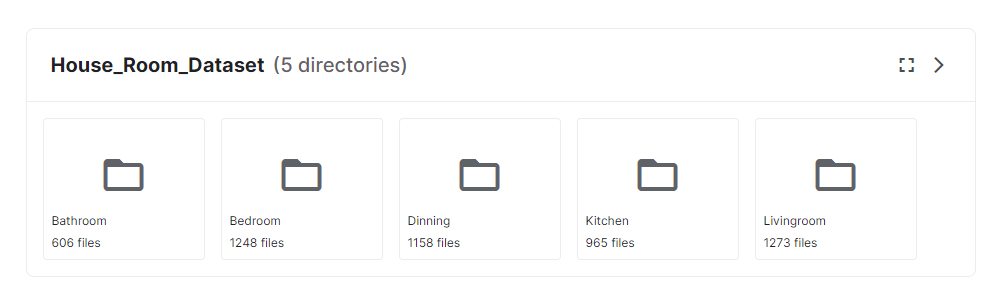

Por este motivo elegimos la siguiente métrica: torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases), ya que calcula la métrica por cada clase en forma separada, y luego hace el promedio (con igual peso para cada clase). Es decir, NO hace el promedio por muestra (habitación).

## Funciones de train y test genéricas para todos los modelos

In [18]:
# Recibe los siguientes parámetros:
# model: el modelo a entrenar.
# criterion: función de pérdida a utilizar.
# optimizer: optimizador a utilizar.
# train_loader: set de datos de entrenamiento.
# valid_loader: set de datos de validación.
# epochs: cantidad de épocas a entrenar.
# model_name: ruta y nombre del modelo para poder almacenarlo.

# Devuelve lo siguiente:
# model: el modelo que se envió por parámetro.
# history: métricas y función de pérdida de entrenamiento y validación para cada época.
# num_epoch_best_val_acc: el número de época que obtuvo la mejor métrica de validación.
# best_valid_acc: la mejor métrica de validación. 

def train(model, criterion, optimizer, train_loader, valid_loader, epochs,model_name):

    accuracy_metric = torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases)# average='weighted'

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # Aca vamos guardando la mejor accuracy para luego guardar el mejor modelo
    best_valid_acc = 0.0 
    num_epoch = 0
    num_epoch_best_val_acc = 0
    
    for epoch in range(epochs):
        num_epoch += 1
        # Ponemos el modelo en modo entrenamiento.
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Ponemos el modelo en modo validación.
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            #print("valid target:",valid_target)
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            #print("output:",output.to("cpu"))
            
            epoch_valid_loss += criterion(output, valid_target).item()
            acuracy_step = accuracy_metric(output, valid_target).item()
            epoch_valid_accuracy += acuracy_step
            #print("Accuracy del paso: ",acuracy_step)
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
        
        # Si la métrica de validación es mejor que la almacenada anteriormente.
        if (epoch_valid_accuracy > best_valid_acc):
            # Nos quedamos con la nueva métrica de validación.
            best_valid_acc = epoch_valid_accuracy
            # Gurdamos el modelo como candidato.
            torch.save(model.state_dict(), model_name)
            # Nos quedamos con el número de época actual.
            num_epoch_best_val_acc = num_epoch

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history, num_epoch_best_val_acc, best_valid_acc

In [19]:
# Recibe los siguientes parámetros:
# model: el modelo a probar.
# model_loss: función de pérdida.
# model_params: ruta y nombre del modelo para poder cargar sus parámetros.
# test_loader: set de datos de pruebas.

# Devuelve lo siguiente:
# test_loss: error de la prueba.
# test_accuracy: métrica de la prueba.

def test(model, model_loss, model_params, test_loader):

  accuracy_metric = torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases)# average='weighted'

  if torch.cuda.is_available():
     model.to("cuda")
     accuracy_metric.to("cuda")

  model.load_state_dict(torch.load(model_params))
  model.eval()
  test_loss = 0.0
  test_accuracy = 0.0

  for test_data, test_target in test_loader:
    if torch.cuda.is_available():
          test_data, test_target = test_data.cuda(), test_target.cuda()
    output = model(test_data)
    test_loss += model_loss(output, test_target).item()
    test_accuracy += accuracy_metric(output, test_target).item()

  test_loss = test_loss / len(test_loader)
  test_accuracy = test_accuracy / len(test_loader)

  print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))
  return test_loss, test_accuracy

## Funcion para hacer inferencia

In [20]:
def inferencia(model, image_path, model_params,transforms):
  img_inferir = Image.open(image_path)
  print("Imagen a analizar: ")
  #img_inferir.show()
  display(img_inferir)

  #Hacemos las transformaciones necesarias sobre la imagen
  img_normalized = transforms(img_inferir).float()
  img_normalized = img_normalized.unsqueeze_(0)

  #Pasamos la imagen y el modelo a GPU
  if torch.cuda.is_available():
     model.to("cuda")
     img_normalized = img_normalized.to("cuda")
   
  #Cargamos el modelo guardado 
  model.load_state_dict(torch.load(model_params))

  #Hacemos la evaluacion
  with torch.no_grad():
    model.eval()
    output =model(img_normalized)
    print("Pesos de salida del modelo: ",output)
    index = output.data.cpu().numpy().argmax()
    classes = set.classes
    class_name = classes[index]
    return class_name


## Clases necesarias para aplicar autoaugment

In [ ]:
class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [ ]:
class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform = transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

## VGG 19 con trasfer learning

### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [21]:
weights_vgg19 = VGG19_Weights.IMAGENET1K_V1
transforms_vgg19 = weights_vgg19.transforms()

train_ds_vgg19 = copy.deepcopy(train_ds)
val_ds_vgg19 = copy.deepcopy(val_ds)
test_ds_vgg19 = copy.deepcopy(test_ds)

#Aplicamos las transformaciones del modelo.
train_ds_vgg19.dataset.transform = transforms_vgg19
val_ds_vgg19.dataset.transform = transforms_vgg19
test_ds_vgg19.dataset.transform = transforms_vgg19

train_loader_vgg19 = torch.utils.data.DataLoader(train_ds_vgg19, batch_size=32, shuffle=True)
valid_loader_vgg19 = torch.utils.data.DataLoader(val_ds_vgg19, batch_size=32, shuffle=True)
test_loader_vgg19 = torch.utils.data.DataLoader(test_ds_vgg19, batch_size=32, shuffle=True)

### Transfer learning (feature extraction)

In [22]:
# Se crea el modelo.
vgg19_model = modelos.vgg19(weights=weights_vgg19)

vgg19_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [23]:
# Congelamos los parametros de la red.
for param in vgg19_model.parameters():
    param.requires_grad = False

In [24]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [25]:
vgg19_model.to("cuda")
torchsummary.summary(vgg19_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Definición de optimizador y función de pérdida

In [26]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/vgg19_model.pth'

### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_vgg19, best_epoch, best_acc_val_vgg19 = train(vgg19_model, criterion, optimizer_ft, train_loader_vgg19, valid_loader_vgg19, 20, model_name)

Epoch: 1/20 - Train loss 1.148370 - Train Accuracy 0.550866 - Valid Loss 0.800581 - Valid Accuracy 0.771566
Epoch: 2/20 - Train loss 0.754267 - Train Accuracy 0.744867 - Valid Loss 0.649380 - Valid Accuracy 0.793690
Epoch: 3/20 - Train loss 0.661649 - Train Accuracy 0.768450 - Valid Loss 0.571185 - Valid Accuracy 0.825575
Epoch: 4/20 - Train loss 0.605117 - Train Accuracy 0.786496 - Valid Loss 0.552743 - Valid Accuracy 0.817573
Epoch: 5/20 - Train loss 0.574488 - Train Accuracy 0.796493 - Valid Loss 0.528103 - Valid Accuracy 0.839643
Epoch: 6/20 - Train loss 0.560839 - Train Accuracy 0.795548 - Valid Loss 0.509430 - Valid Accuracy 0.837101
Epoch: 7/20 - Train loss 0.548677 - Train Accuracy 0.800995 - Valid Loss 0.502547 - Valid Accuracy 0.830291
Epoch: 8/20 - Train loss 0.536696 - Train Accuracy 0.809654 - Valid Loss 0.485371 - Valid Accuracy 0.846078
Epoch: 9/20 - Train loss 0.524349 - Train Accuracy 0.816394 - Valid Loss 0.482313 - Valid Accuracy 0.849326
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 16


### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_vgg19, test_accuracy_vgg19 = test(vgg19_model, criterion, model_name, test_loader_vgg19)

El modelo logro un error de 0.485713 y una accuracy de 0.806908


### Gráficos de resultados

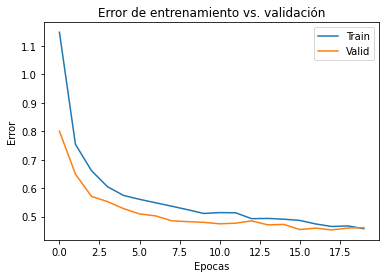

In [ ]:
plt.plot(history_vgg19["train_loss"])
plt.plot(history_vgg19["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

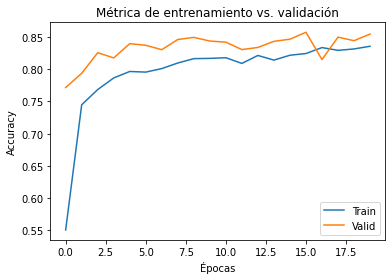

In [ ]:
plt.plot(history_vgg19["train_acc"])
plt.plot(history_vgg19["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

### Inferencias sobre el modelo

Realizamos inferencias del modelo sobre imagenes diferentes del dataset original

#### Inferencia 1

In [27]:
image_path = "/content/banio2.jpg"

clase_out =  inferencia(vgg19_model, image_path, model_name,weights_vgg19.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

#### Inferencia 2

In [29]:
image_path = "/content/cocina.jpg"

clase_out =  inferencia(vgg19_model, image_path, model_name,weights_vgg19.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

#### Inferencia 3

In [30]:
image_path = "/content/living.jpg"

clase_out =  inferencia(vgg19_model, image_path, model_name,weights_vgg19.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

#### Inferencia 4

In [33]:
image_path = "/content/pieza.jpg"

clase_out =  inferencia(vgg19_model, image_path, model_name,weights_vgg19.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

## Alexnet con transfer learning

### Con data augmentation

#### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy(train_ds)
val_ds_alexnet = copy.deepcopy(val_ds)
test_ds_alexnet = copy.deepcopy(test_ds)

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet
#print(test_ds_alexnet[0][0].shape)

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

#### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model.pth'

#### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da, best_epoch, best_acc_val_alexnet_da = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.176773 - Train Accuracy 0.515769 - Valid Loss 0.907737 - Valid Accuracy 0.679245
Epoch: 2/20 - Train loss 0.859300 - Train Accuracy 0.666671 - Valid Loss 0.788409 - Valid Accuracy 0.728462
Epoch: 3/20 - Train loss 0.778122 - Train Accuracy 0.704991 - Valid Loss 0.747420 - Valid Accuracy 0.718316
Epoch: 4/20 - Train loss 0.732563 - Train Accuracy 0.735830 - Valid Loss 0.699846 - Valid Accuracy 0.757260
Epoch: 5/20 - Train loss 0.696454 - Train Accuracy 0.739509 - Valid Loss 0.692709 - Valid Accuracy 0.742981
Epoch: 6/20 - Train loss 0.684641 - Train Accuracy 0.744920 - Valid Loss 0.678228 - Valid Accuracy 0.740209
Epoch: 7/20 - Train loss 0.656568 - Train Accuracy 0.760115 - Valid Loss 0.669688 - Valid Accuracy 0.749268
Epoch: 8/20 - Train loss 0.636316 - Train Accuracy 0.767856 - Valid Loss 0.663679 - Valid Accuracy 0.761245
Epoch: 9/20 - Train loss 0.624223 - Train Accuracy 0.758985 - Valid Loss 0.658611 - Valid Accuracy 0.773321
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 11


#### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da, test_accuracy_alexnet_da = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.667426 y una accuracy de 0.737030


#### Gráficos de resultados

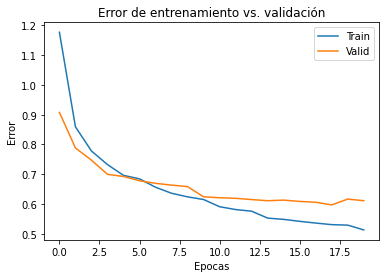

In [ ]:
plt.plot(history_alexnet_da["train_loss"])
plt.plot(history_alexnet_da["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

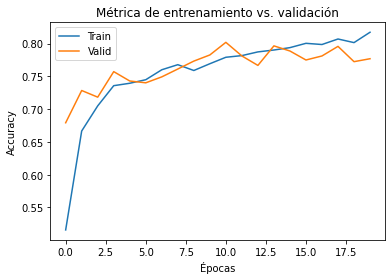

In [ ]:
plt.plot(history_alexnet_da["train_acc"])
plt.plot(history_alexnet_da["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

### Sin data augmentation

#### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

#Tomamos dataset original sin data augmentation (nuestras transformaciones).
train_ds_alexnet = copy.deepcopy(train_ds_original)
val_ds_alexnet = copy.deepcopy(val_ds_original)
test_ds_alexnet = copy.deepcopy(test_ds_original)

#Pasamos a tensor.
train_ds_alexnet.dataset.transform = transform_to_tensor
val_ds_alexnet.dataset.transform = transform_to_tensor
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)#32
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)#32
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)#32

#### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

#### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_sin_dat_aug.pth'

#### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_not_da, best_epoch, best_acc_val_alexnet_not_da = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.172525 - Train Accuracy 0.514939 - Valid Loss 0.901395 - Valid Accuracy 0.688460
Epoch: 2/20 - Train loss 0.864499 - Train Accuracy 0.675450 - Valid Loss 0.788025 - Valid Accuracy 0.679633
Epoch: 3/20 - Train loss 0.783876 - Train Accuracy 0.709727 - Valid Loss 0.737077 - Valid Accuracy 0.744410
Epoch: 4/20 - Train loss 0.727212 - Train Accuracy 0.716623 - Valid Loss 0.699317 - Valid Accuracy 0.748494
Epoch: 5/20 - Train loss 0.702346 - Train Accuracy 0.732053 - Valid Loss 0.675558 - Valid Accuracy 0.748201
Epoch: 6/20 - Train loss 0.682201 - Train Accuracy 0.748024 - Valid Loss 0.670511 - Valid Accuracy 0.751825
Epoch: 7/20 - Train loss 0.659067 - Train Accuracy 0.748833 - Valid Loss 0.658830 - Valid Accuracy 0.755126
Epoch: 8/20 - Train loss 0.629863 - Train Accuracy 0.760531 - Valid Loss 0.643568 - Valid Accuracy 0.772006
Epoch: 9/20 - Train loss 0.621829 - Train Accuracy 0.759606 - Valid Loss 0.640262 - Valid Accuracy 0.763304
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 19


#### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_not_da, test_accuracy_alexnet_not_da = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.670455 y una accuracy de 0.717980


#### Gráficos de resultados

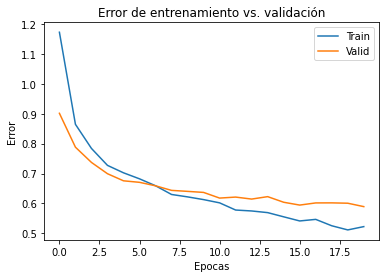

In [ ]:
plt.plot(history_alexnet_not_da["train_loss"])
plt.plot(history_alexnet_not_da["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

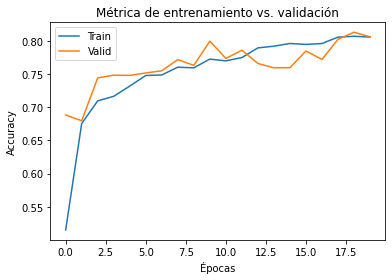

In [ ]:
plt.plot(history_alexnet_not_da["train_acc"])
plt.plot(history_alexnet_not_da["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

### Pruebas con diferentes casos de data augmentation

#### Caso 1 - Solo rotaciones

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c1 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomRotation(degrees=180)]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c1
val_ds_alexnet.dataset.transform = aug_data_transforms_c1
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet
#print(test_ds_alexnet[0][0].shape)

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c1.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c1, best_epoch, best_acc_val_alexnet_da_c1 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.202942 - Train Accuracy 0.503545 - Valid Loss 0.926086 - Valid Accuracy 0.684550
Epoch: 2/20 - Train loss 0.869290 - Train Accuracy 0.673061 - Valid Loss 0.820788 - Valid Accuracy 0.701142
Epoch: 3/20 - Train loss 0.787125 - Train Accuracy 0.695436 - Valid Loss 0.778569 - Valid Accuracy 0.713195
Epoch: 4/20 - Train loss 0.742920 - Train Accuracy 0.715858 - Valid Loss 0.759855 - Valid Accuracy 0.725457
Epoch: 5/20 - Train loss 0.712592 - Train Accuracy 0.731039 - Valid Loss 0.726288 - Valid Accuracy 0.731426
Epoch: 6/20 - Train loss 0.688315 - Train Accuracy 0.741347 - Valid Loss 0.719372 - Valid Accuracy 0.724951
Epoch: 7/20 - Train loss 0.659770 - Train Accuracy 0.742814 - Valid Loss 0.698785 - Valid Accuracy 0.732081
Epoch: 8/20 - Train loss 0.640183 - Train Accuracy 0.757576 - Valid Loss 0.696648 - Valid Accuracy 0.721138
Epoch: 9/20 - Train loss 0.626884 - Train Accuracy 0.759852 - Valid Loss 0.686196 - Valid Accuracy 0.756051
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 19


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c1, test_accuracy_alexnet_da_c1 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.569362 y una accuracy de 0.824155


##### Gráficos de resultados

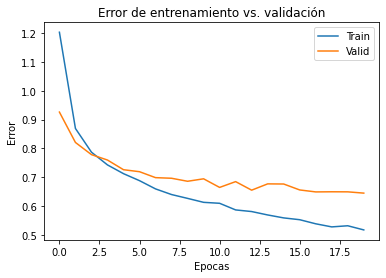

In [ ]:
plt.plot(history_alexnet_da_c1["train_loss"])
plt.plot(history_alexnet_da_c1["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

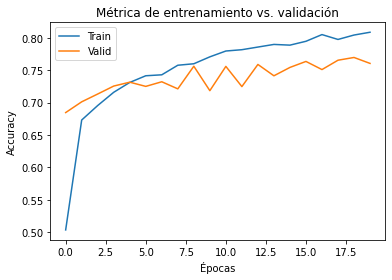

In [ ]:
plt.plot(history_alexnet_da_c1["train_acc"])
plt.plot(history_alexnet_da_c1["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 2 - Solo color jitter

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c2 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05, hue=0.05)]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c2
val_ds_alexnet.dataset.transform = aug_data_transforms_c2
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet
#print(test_ds_alexnet[0][0].shape)

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c2.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c2, best_epoch, best_acc_val_alexnet_da_c2 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.194771 - Train Accuracy 0.498962 - Valid Loss 0.919954 - Valid Accuracy 0.706860
Epoch: 2/20 - Train loss 0.876598 - Train Accuracy 0.664171 - Valid Loss 0.807740 - Valid Accuracy 0.716940
Epoch: 3/20 - Train loss 0.784826 - Train Accuracy 0.707267 - Valid Loss 0.767617 - Valid Accuracy 0.727636
Epoch: 4/20 - Train loss 0.738544 - Train Accuracy 0.714430 - Valid Loss 0.750207 - Valid Accuracy 0.725445
Epoch: 5/20 - Train loss 0.702038 - Train Accuracy 0.737047 - Valid Loss 0.713561 - Valid Accuracy 0.723116
Epoch: 6/20 - Train loss 0.681294 - Train Accuracy 0.742709 - Valid Loss 0.699392 - Valid Accuracy 0.741124
Epoch: 7/20 - Train loss 0.661983 - Train Accuracy 0.764717 - Valid Loss 0.684839 - Valid Accuracy 0.779310
Epoch: 8/20 - Train loss 0.631757 - Train Accuracy 0.752536 - Valid Loss 0.682890 - Valid Accuracy 0.741843
Epoch: 9/20 - Train loss 0.631911 - Train Accuracy 0.775685 - Valid Loss 0.670998 - Valid Accuracy 0.757073
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 17


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c2, test_accuracy_alexnet_da_c2 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.586355 y una accuracy de 0.801612


##### Gráficos de resultados

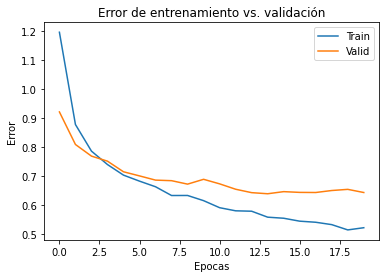

In [ ]:
plt.plot(history_alexnet_da_c2["train_loss"])
plt.plot(history_alexnet_da_c2["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

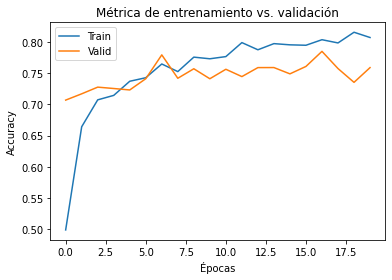

In [ ]:
plt.plot(history_alexnet_da_c2["train_acc"])
plt.plot(history_alexnet_da_c2["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 3 - Solo filtro gaussiano

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c3 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c3
val_ds_alexnet.dataset.transform = aug_data_transforms_c3
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet
#print(test_ds_alexnet[0][0].shape)

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c3.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c3, best_epoch, best_acc_val_alexnet_da_c3 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.190551 - Train Accuracy 0.513531 - Valid Loss 0.933319 - Valid Accuracy 0.662493
Epoch: 2/20 - Train loss 0.857033 - Train Accuracy 0.669464 - Valid Loss 0.810977 - Valid Accuracy 0.712882
Epoch: 3/20 - Train loss 0.777148 - Train Accuracy 0.709164 - Valid Loss 0.783899 - Valid Accuracy 0.703123
Epoch: 4/20 - Train loss 0.733023 - Train Accuracy 0.724756 - Valid Loss 0.735150 - Valid Accuracy 0.721261
Epoch: 5/20 - Train loss 0.701714 - Train Accuracy 0.743592 - Valid Loss 0.722176 - Valid Accuracy 0.745179
Epoch: 6/20 - Train loss 0.679831 - Train Accuracy 0.738187 - Valid Loss 0.712832 - Valid Accuracy 0.712709
Epoch: 7/20 - Train loss 0.648000 - Train Accuracy 0.753411 - Valid Loss 0.689807 - Valid Accuracy 0.744349
Epoch: 8/20 - Train loss 0.630134 - Train Accuracy 0.753329 - Valid Loss 0.686440 - Valid Accuracy 0.769726
Epoch: 9/20 - Train loss 0.622976 - Train Accuracy 0.761877 - Valid Loss 0.673703 - Valid Accuracy 0.739319
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 8


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c3, test_accuracy_alexnet_da_c3 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.619950 y una accuracy de 0.777613


##### Gráficos de resultados

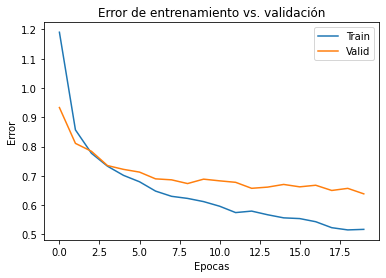

In [ ]:
plt.plot(history_alexnet_da_c3["train_loss"])
plt.plot(history_alexnet_da_c3["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

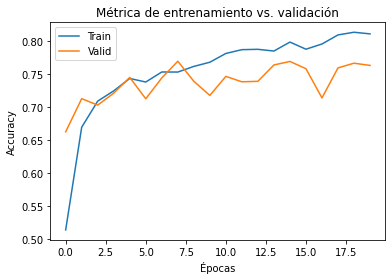

In [ ]:
plt.plot(history_alexnet_da_c3["train_acc"])
plt.plot(history_alexnet_da_c3["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 4 - Rotaciones + color jitter

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c4 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomRotation(degrees=180)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05, hue=0.05)]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c4
val_ds_alexnet.dataset.transform = aug_data_transforms_c4
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

#Generamos los dataloaaders
train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c4.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c4, best_epoch, best_acc_val_alexnet_da_c4 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.211242 - Train Accuracy 0.481973 - Valid Loss 0.963040 - Valid Accuracy 0.649387
Epoch: 2/20 - Train loss 0.881942 - Train Accuracy 0.659687 - Valid Loss 0.819774 - Valid Accuracy 0.710105
Epoch: 3/20 - Train loss 0.784341 - Train Accuracy 0.698917 - Valid Loss 0.765839 - Valid Accuracy 0.724465
Epoch: 4/20 - Train loss 0.728913 - Train Accuracy 0.725967 - Valid Loss 0.753588 - Valid Accuracy 0.720430
Epoch: 5/20 - Train loss 0.704229 - Train Accuracy 0.732140 - Valid Loss 0.729101 - Valid Accuracy 0.715591
Epoch: 6/20 - Train loss 0.675082 - Train Accuracy 0.742518 - Valid Loss 0.708208 - Valid Accuracy 0.730837
Epoch: 7/20 - Train loss 0.661817 - Train Accuracy 0.752777 - Valid Loss 0.694510 - Valid Accuracy 0.736420
Epoch: 8/20 - Train loss 0.646935 - Train Accuracy 0.764730 - Valid Loss 0.693889 - Valid Accuracy 0.736763
Epoch: 9/20 - Train loss 0.627268 - Train Accuracy 0.765907 - Valid Loss 0.679294 - Valid Accuracy 0.753610
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 16


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c4, test_accuracy_alexnet_da_c4 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.580951 y una accuracy de 0.747537


##### Gráficos de resultados

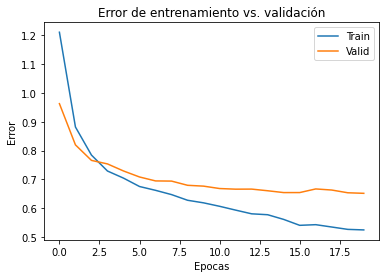

In [ ]:
plt.plot(history_alexnet_da_c4["train_loss"])
plt.plot(history_alexnet_da_c4["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

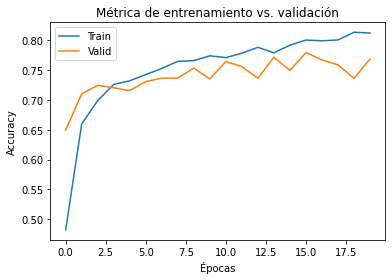

In [ ]:
plt.plot(history_alexnet_da_c4["train_acc"])
plt.plot(history_alexnet_da_c4["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 5 - Rotaciones + filtro gaussiano

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c5 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomRotation(degrees=180)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c5
val_ds_alexnet.dataset.transform = aug_data_transforms_c5
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

#Generamos lo dataloaders
train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c5.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c5, best_epoch, best_acc_val_alexnet_da_c5 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.168180 - Train Accuracy 0.515470 - Valid Loss 0.886805 - Valid Accuracy 0.678751
Epoch: 2/20 - Train loss 0.864498 - Train Accuracy 0.671500 - Valid Loss 0.811350 - Valid Accuracy 0.701261
Epoch: 3/20 - Train loss 0.790368 - Train Accuracy 0.695824 - Valid Loss 0.755664 - Valid Accuracy 0.739346
Epoch: 4/20 - Train loss 0.743697 - Train Accuracy 0.715712 - Valid Loss 0.717470 - Valid Accuracy 0.737736
Epoch: 5/20 - Train loss 0.703549 - Train Accuracy 0.736152 - Valid Loss 0.704028 - Valid Accuracy 0.749030
Epoch: 6/20 - Train loss 0.683652 - Train Accuracy 0.743378 - Valid Loss 0.714612 - Valid Accuracy 0.741847
Epoch: 7/20 - Train loss 0.660860 - Train Accuracy 0.753403 - Valid Loss 0.709411 - Valid Accuracy 0.748709
Epoch: 8/20 - Train loss 0.637747 - Train Accuracy 0.766903 - Valid Loss 0.674408 - Valid Accuracy 0.735467
Epoch: 9/20 - Train loss 0.620857 - Train Accuracy 0.775587 - Valid Loss 0.670614 - Valid Accuracy 0.758083
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 14


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c5, test_accuracy_alexnet_da_c5 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.598002 y una accuracy de 0.767155


##### Gráficos de resultados

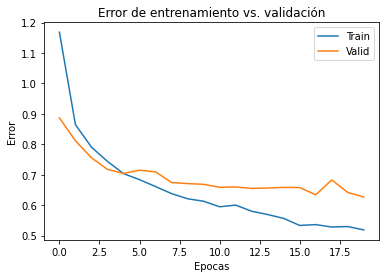

In [ ]:
plt.plot(history_alexnet_da_c5["train_loss"])
plt.plot(history_alexnet_da_c5["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

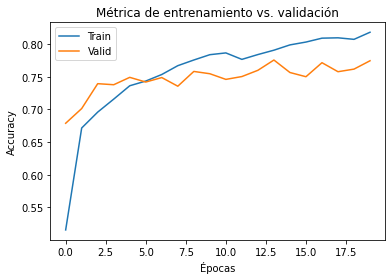

In [ ]:
plt.plot(history_alexnet_da_c5["train_acc"])
plt.plot(history_alexnet_da_c5["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 6 - Color jitter + filtro gaussiano

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c6 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05, hue=0.05)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c6
val_ds_alexnet.dataset.transform = aug_data_transforms_c6
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

#Genramos los dataloaders
train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_c6.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c6, best_epoch, best_acc_val_alexnet_da_c6 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.194246 - Train Accuracy 0.499653 - Valid Loss 0.916248 - Valid Accuracy 0.624022
Epoch: 2/20 - Train loss 0.866273 - Train Accuracy 0.664300 - Valid Loss 0.799525 - Valid Accuracy 0.705062
Epoch: 3/20 - Train loss 0.778310 - Train Accuracy 0.698613 - Valid Loss 0.762544 - Valid Accuracy 0.724594
Epoch: 4/20 - Train loss 0.741349 - Train Accuracy 0.721433 - Valid Loss 0.731855 - Valid Accuracy 0.713328
Epoch: 5/20 - Train loss 0.704006 - Train Accuracy 0.739517 - Valid Loss 0.722170 - Valid Accuracy 0.731261
Epoch: 6/20 - Train loss 0.668458 - Train Accuracy 0.761601 - Valid Loss 0.713715 - Valid Accuracy 0.744703
Epoch: 7/20 - Train loss 0.660215 - Train Accuracy 0.759541 - Valid Loss 0.685594 - Valid Accuracy 0.748965
Epoch: 8/20 - Train loss 0.643890 - Train Accuracy 0.762375 - Valid Loss 0.704841 - Valid Accuracy 0.732996
Epoch: 9/20 - Train loss 0.630017 - Train Accuracy 0.770608 - Valid Loss 0.679018 - Valid Accuracy 0.752962
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 19


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c6, test_accuracy_alexnet_da_c6 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.584959 y una accuracy de 0.768727


##### Gráficos de resultados

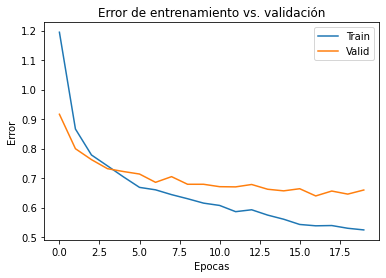

In [ ]:
plt.plot(history_alexnet_da_c6["train_loss"])
plt.plot(history_alexnet_da_c6["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

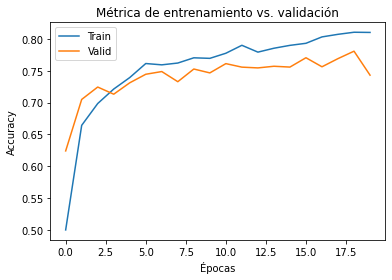

In [ ]:
plt.plot(history_alexnet_da_c6["train_acc"])
plt.plot(history_alexnet_da_c6["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 7 - Gray Scale

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las trnasformacion de data augmentation a realizar
aug_data_transforms_c7 = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.Grayscale(num_output_channels=3)]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_c7
val_ds_alexnet.dataset.transform = aug_data_transforms_c7
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

#Generamos los dataloaders
train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_da_gray_scale.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_da_c7, best_epoch, best_acc_val_alexnet_da_c7 = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.155610 - Train Accuracy 0.525980 - Valid Loss 0.914991 - Valid Accuracy 0.635878
Epoch: 2/20 - Train loss 0.868923 - Train Accuracy 0.672204 - Valid Loss 0.798014 - Valid Accuracy 0.717115
Epoch: 3/20 - Train loss 0.783798 - Train Accuracy 0.698451 - Valid Loss 0.749015 - Valid Accuracy 0.741201
Epoch: 4/20 - Train loss 0.738775 - Train Accuracy 0.729346 - Valid Loss 0.747993 - Valid Accuracy 0.727384
Epoch: 5/20 - Train loss 0.714097 - Train Accuracy 0.730914 - Valid Loss 0.704849 - Valid Accuracy 0.739765
Epoch: 6/20 - Train loss 0.677123 - Train Accuracy 0.745906 - Valid Loss 0.713401 - Valid Accuracy 0.738410
Epoch: 7/20 - Train loss 0.664744 - Train Accuracy 0.745680 - Valid Loss 0.700227 - Valid Accuracy 0.750736
Epoch: 8/20 - Train loss 0.645643 - Train Accuracy 0.763136 - Valid Loss 0.702560 - Valid Accuracy 0.729433
Epoch: 9/20 - Train loss 0.625298 - Train Accuracy 0.770935 - Valid Loss 0.684060 - Valid Accuracy 0.751105
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 19


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da_c7, test_accuracy_alexnet_da_c7 = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.600761 y una accuracy de 0.756872


##### Gráficos de resultados

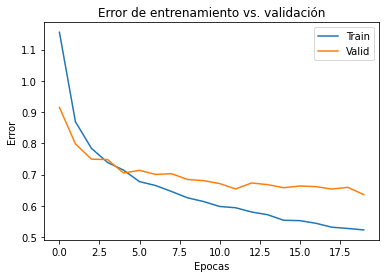

In [ ]:
plt.plot(history_alexnet_da_c7["train_loss"])
plt.plot(history_alexnet_da_c7["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

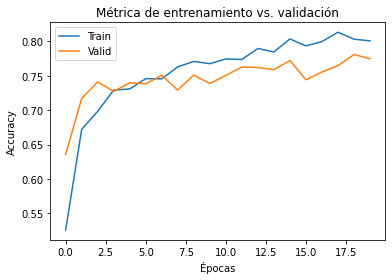

In [ ]:
plt.plot(history_alexnet_da_c7["train_acc"])
plt.plot(history_alexnet_da_c7["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

#### Caso 8  - Con AutoAugmentation

##### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy((train_ds_original))
val_ds_alexnet = copy.deepcopy((val_ds_original))
test_ds_alexnet = copy.deepcopy((test_ds_original))

#Definimos las transformacion de data augmentation a realizar
aug_data_transforms_auto = torchvision.transforms.Compose([
                        ImageNetPolicy(),
                        torchvision.transforms.ToTensor()
                      ])


#Aplicamos transformaciones de data augmentation
train_ds_alexnet.dataset.transform = aug_data_transforms_auto
val_ds_alexnet.dataset.transform = aug_data_transforms_auto
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones del modelo.
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

#Genramos los dataloaders
train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


##### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
alexnet_model = modelos.alexnet(weights=weights_alexnet)

alexnet_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
# Congelamos los parametros de la red.
for param in alexnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_model_autoaugment.pth'

##### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_alexnet_autoaugm, best_epoch, best_acc_val_alexnet_autoaugm = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 20, model_name)

Epoch: 1/20 - Train loss 1.199310 - Train Accuracy 0.491253 - Valid Loss 0.908778 - Valid Accuracy 0.672864
Epoch: 2/20 - Train loss 0.868041 - Train Accuracy 0.681304 - Valid Loss 0.811066 - Valid Accuracy 0.725503
Epoch: 3/20 - Train loss 0.770068 - Train Accuracy 0.712714 - Valid Loss 0.745640 - Valid Accuracy 0.748595
Epoch: 4/20 - Train loss 0.729160 - Train Accuracy 0.715001 - Valid Loss 0.718095 - Valid Accuracy 0.747507
Epoch: 5/20 - Train loss 0.707614 - Train Accuracy 0.731660 - Valid Loss 0.699906 - Valid Accuracy 0.753920
Epoch: 6/20 - Train loss 0.665233 - Train Accuracy 0.749083 - Valid Loss 0.690796 - Valid Accuracy 0.738263
Epoch: 7/20 - Train loss 0.647104 - Train Accuracy 0.765359 - Valid Loss 0.687329 - Valid Accuracy 0.747356
Epoch: 8/20 - Train loss 0.632010 - Train Accuracy 0.759266 - Valid Loss 0.674278 - Valid Accuracy 0.739212
Epoch: 9/20 - Train loss 0.614763 - Train Accuracy 0.775022 - Valid Loss 0.689003 - Valid Accuracy 0.738707
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 16


##### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_autoaugm, test_accuracy_alexnet_autoaugm = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 0.599485 y una accuracy de 0.777680


##### Gráficos de resultados

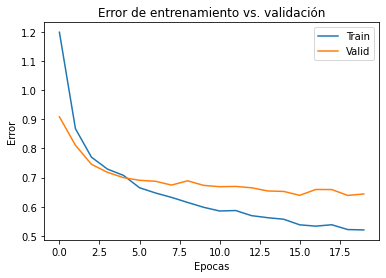

In [ ]:
plt.plot(history_alexnet_autoaugm["train_loss"])
plt.plot(history_alexnet_autoaugm["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

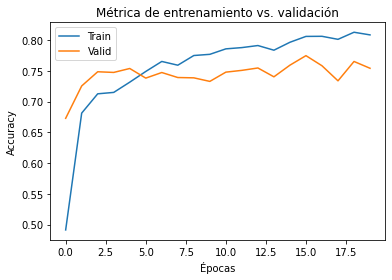

In [ ]:
plt.plot(history_alexnet_autoaugm["train_acc"])
plt.plot(history_alexnet_autoaugm["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

##### Inferencias sobre el modelo

Realizamos inferencias del modelo sobre imagenes diferentes del dataset original

###### Inferencia 1

In [ ]:
image_path = "/content/banio2.jpg"

clase_out =  inferencia(alexnet_model, image_path, model_name,weights_alexnet.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

###### Inferencia 2

In [ ]:
image_path = "/content/cocina.jpg"

clase_out =  inferencia(alexnet_model, image_path, model_name,weights_alexnet.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

###### Inferencia 3

In [ ]:
image_path = "/content/living.jpg"

clase_out =  inferencia(alexnet_model, image_path, model_name,weights_alexnet.transforms())
print("El modelo predijo que la clase es: ",clase_out)

Output hidden; open in https://colab.research.google.com to view.

###### Inferencia 4

Imagen a analizar: 


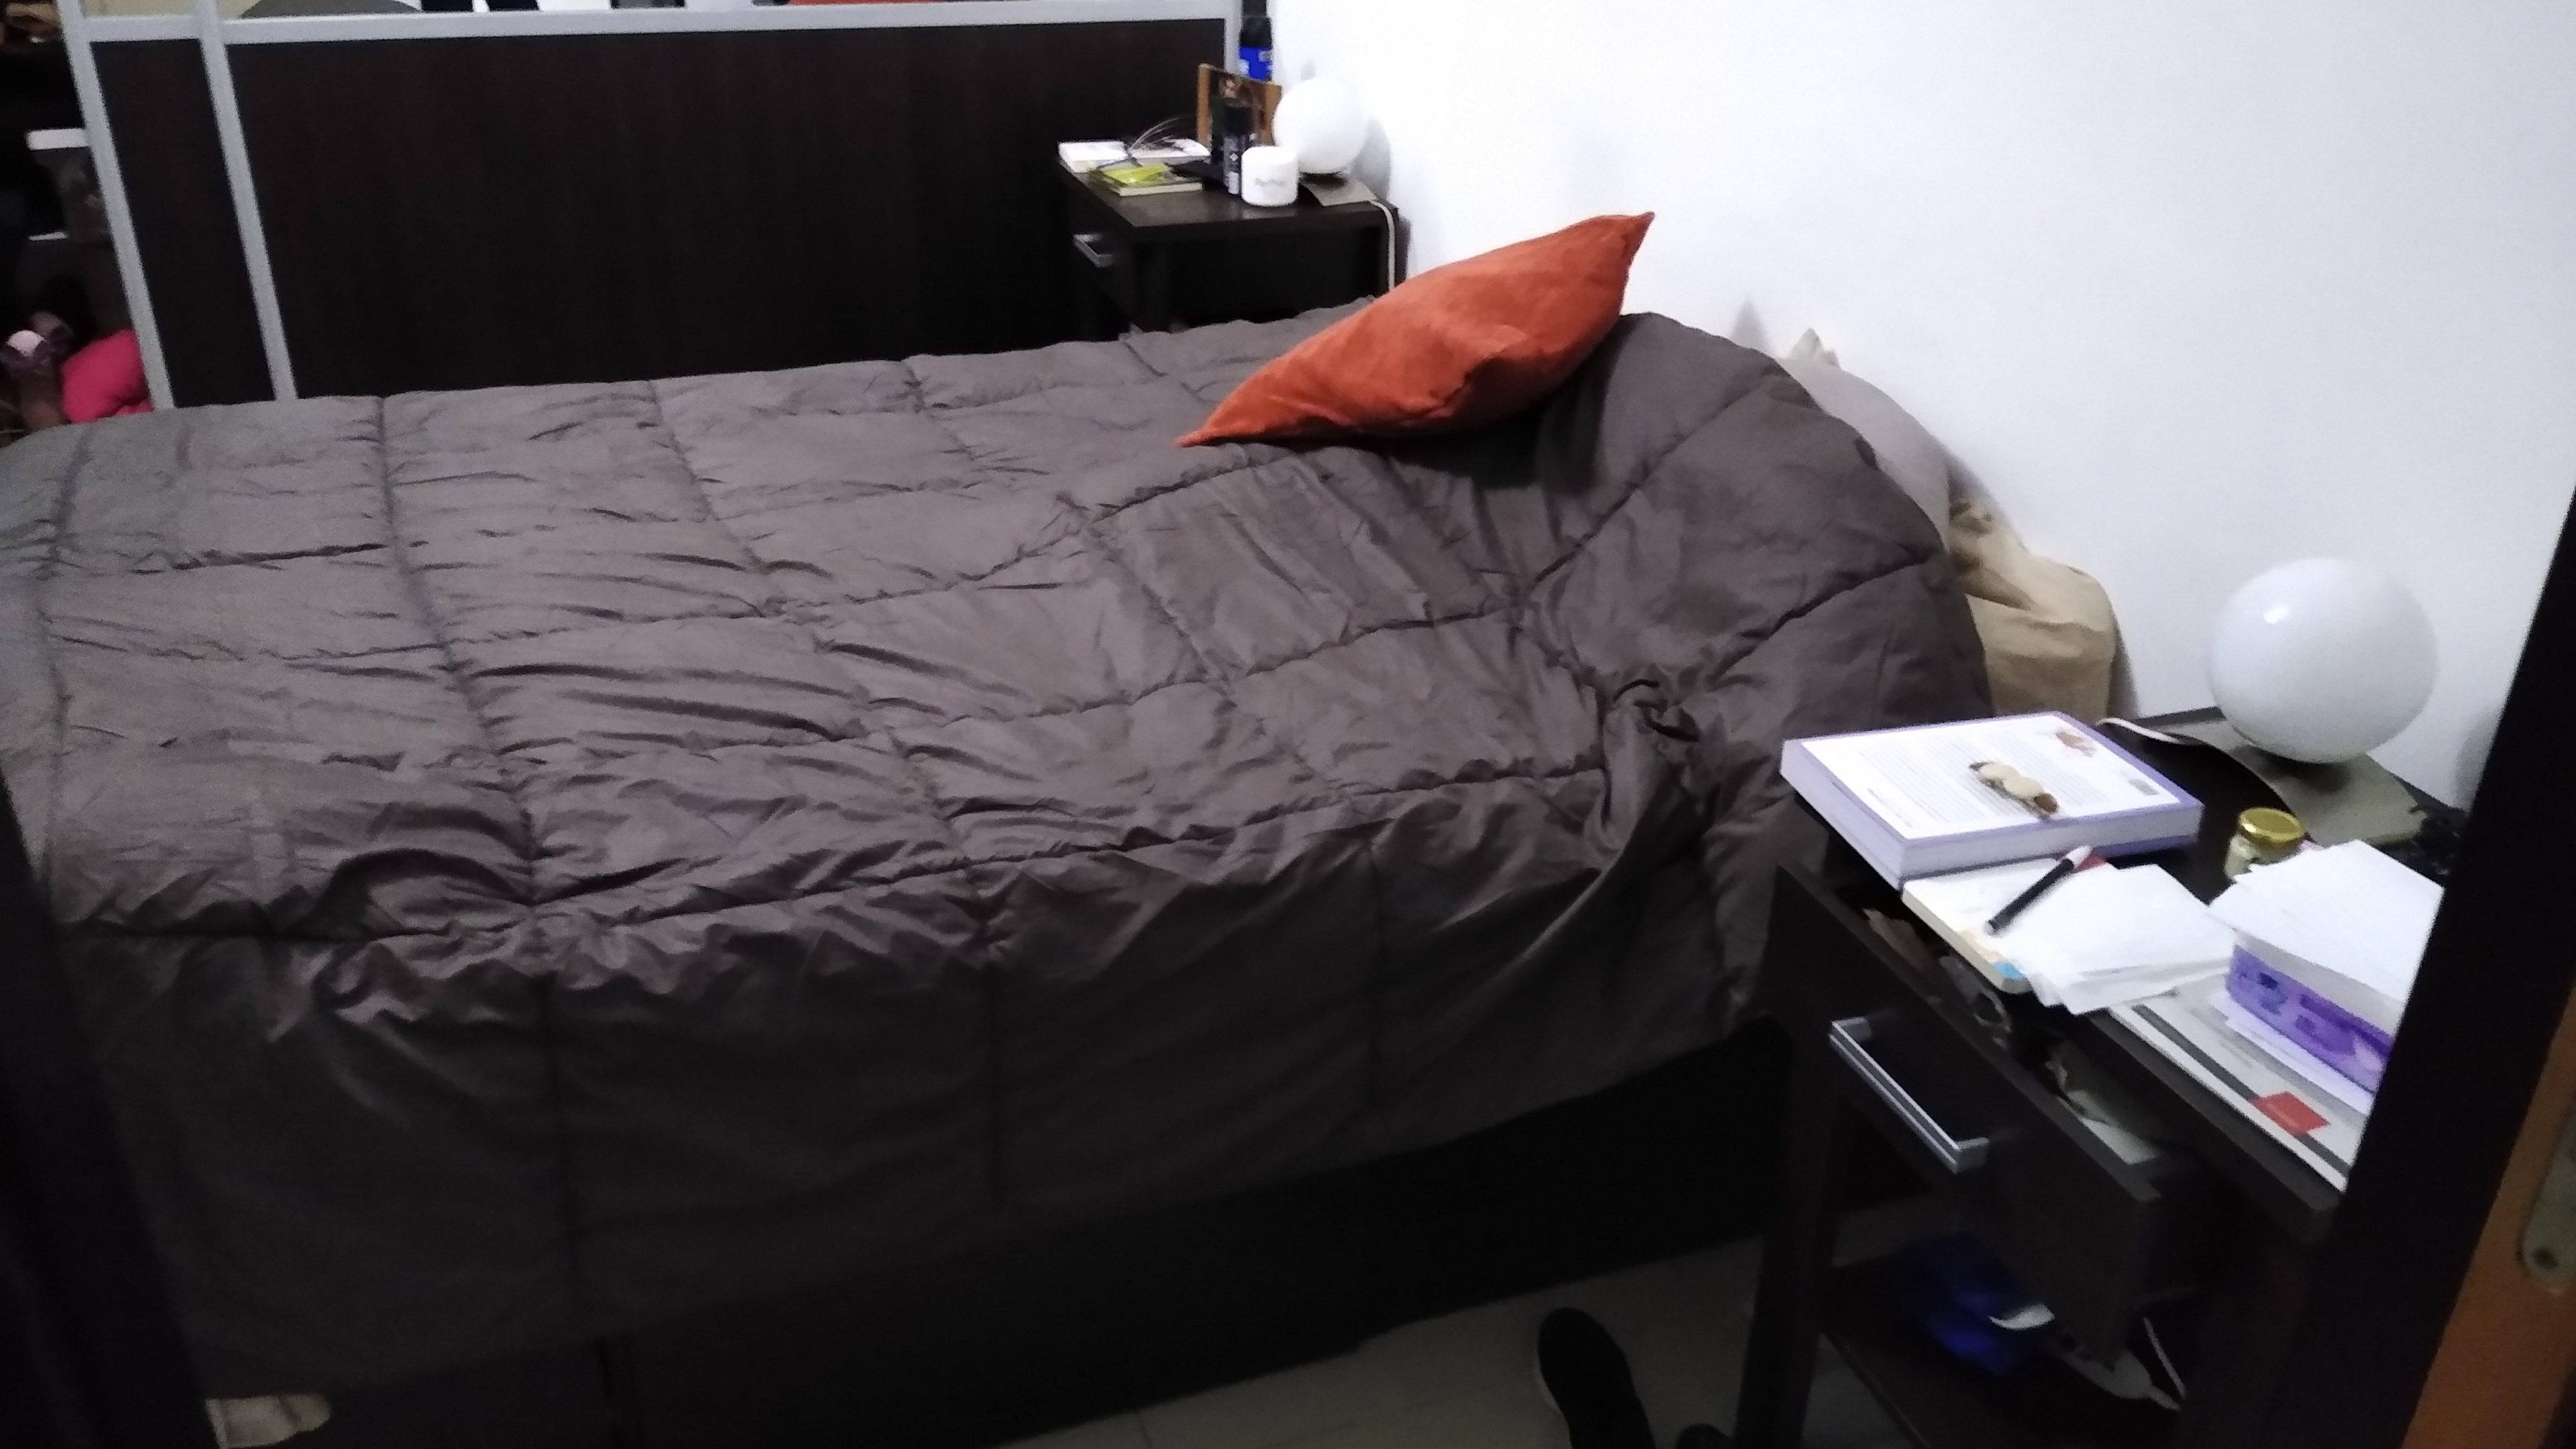

Pesos de salida del modelo:  tensor([[-1.3646,  2.1428, -2.2503, -3.5550, -0.6963]], device='cuda:0')
El modelo predijo que la clase es:  Bedroom


In [ ]:
image_path = "/content/pieza.jpg"

clase_out =  inferencia(alexnet_model, image_path, model_name,weights_alexnet.transforms())
print("El modelo predijo que la clase es: ",clase_out)

## ResNet50 con trasfer learning

### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_resnet50 = ResNet50_Weights.IMAGENET1K_V1
transforms_resnet50 = weights_resnet50.transforms()

train_ds_resnet50 = copy.deepcopy(train_ds)
val_ds_resnet50 = copy.deepcopy(val_ds)
test_ds_resnet50 = copy.deepcopy(test_ds)

#Aplicamos las transformaciones del modelo.
train_ds_resnet50.dataset.transform = transforms_resnet50
val_ds_resnet50.dataset.transform = transforms_resnet50
test_ds_resnet50.dataset.transform = transforms_resnet50
#print(test_ds_resnet50[0][0].shape)

train_loader_resnet50 = torch.utils.data.DataLoader(train_ds_resnet50, batch_size=32, shuffle=True)
valid_loader_resnet50 = torch.utils.data.DataLoader(val_ds_resnet50, batch_size=32, shuffle=True)
test_loader_resnet50 = torch.utils.data.DataLoader(test_ds_resnet50, batch_size=32, shuffle=True)

### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
resnet50_model = modelos.resnet50(weights=weights_resnet50)

resnet50_model.to("cuda")

# Información sobre el modelo.
torchsummary.summary(resnet50_model, input_size=(3, 224, 224))
resnet50_model.modules

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [ ]:
# Congelamos los parametros de la red.
for param in resnet50_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa fully connected por una que a la salida tenga 
# 5 características, porque son 5 clases.
last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
resnet50_model.to("cuda")
torchsummary.summary(resnet50_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/resnet50_model.pth'

### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history_resnet50, best_epoch, best_acc_val_resnet50 = train(resnet50_model, criterion, optimizer_ft, train_loader_resnet50, valid_loader_resnet50, 20, model_name)

Epoch: 1/20 - Train loss 1.428142 - Train Accuracy 0.396640 - Valid Loss 1.254674 - Valid Accuracy 0.605338
Epoch: 2/20 - Train loss 1.155212 - Train Accuracy 0.650166 - Valid Loss 1.046083 - Valid Accuracy 0.737171
Epoch: 3/20 - Train loss 1.001548 - Train Accuracy 0.726054 - Valid Loss 0.935621 - Valid Accuracy 0.729115
Epoch: 4/20 - Train loss 0.898322 - Train Accuracy 0.748394 - Valid Loss 0.852768 - Valid Accuracy 0.772226
Epoch: 5/20 - Train loss 0.834919 - Train Accuracy 0.762562 - Valid Loss 0.791167 - Valid Accuracy 0.767292
Epoch: 6/20 - Train loss 0.784900 - Train Accuracy 0.771525 - Valid Loss 0.744893 - Valid Accuracy 0.771189
Epoch: 7/20 - Train loss 0.742486 - Train Accuracy 0.783854 - Valid Loss 0.727932 - Valid Accuracy 0.763836
Epoch: 8/20 - Train loss 0.725764 - Train Accuracy 0.785565 - Valid Loss 0.692077 - Valid Accuracy 0.780022
Epoch: 9/20 - Train loss 0.694566 - Train Accuracy 0.795791 - Valid Loss 0.686930 - Valid Accuracy 0.757669
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 15


### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_resnet50, test_accuracy_resnet50 = test(resnet50_model, criterion, model_name, test_loader_resnet50)

El modelo logro un error de 0.647360 y una accuracy de 0.776204


### Gráficos de resultados

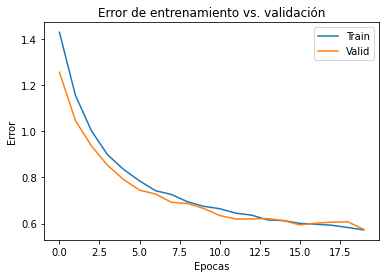

In [ ]:
plt.plot(history_resnet50["train_loss"])
plt.plot(history_resnet50["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

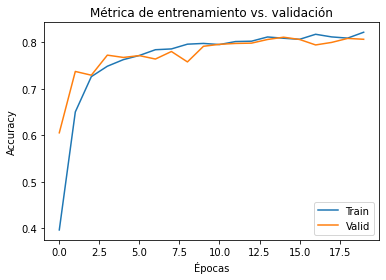

In [ ]:
plt.plot(history_resnet50["train_acc"])
plt.plot(history_resnet50["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

## InceptionV3 con trasfer learning

### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_inceptionv3 = Inception_V3_Weights.IMAGENET1K_V1
transforms_inceptionv3 = weights_inceptionv3.transforms()

train_ds_inceptionv3 = copy.deepcopy(train_ds)
val_ds_inceptionv3 = copy.deepcopy(val_ds)
test_ds_inceptionv3 = copy.deepcopy(test_ds)

#Aplicamos las transformaciones del modelo.
train_ds_inceptionv3.dataset.transform = transforms_inceptionv3
val_ds_inceptionv3.dataset.transform = transforms_inceptionv3
test_ds_inceptionv3.dataset.transform = transforms_inceptionv3
#Notar que en este caso la dimensión de la entrada es diferente.
print(train_ds_inceptionv3[0][0].shape)

train_loader_inceptionv3 = torch.utils.data.DataLoader(train_ds_inceptionv3, batch_size=32, shuffle=True)
valid_loader_inceptionv3 = torch.utils.data.DataLoader(val_ds_inceptionv3, batch_size=32, shuffle=True)
test_loader_inceptionv3 = torch.utils.data.DataLoader(test_ds_inceptionv3, batch_size=32, shuffle=True)

torch.Size([3, 299, 299])


### Transfer learning (feature extraction)

In [ ]:
# Se crea el modelo.
inceptionv3_model = modelos.inception_v3(weights=weights_inceptionv3)

inceptionv3_model.to("cuda")

# Información sobre el modelo.
# Se modifica la dimensión de entrada con respecto a los otros modelos.
torchsummary.summary(inceptionv3_model, input_size=(3, 299, 299))
inceptionv3_model.modules

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

<bound method Module.modules of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(8

In [ ]:
# Congelamos los parametros de la red.
for param in inceptionv3_model.parameters():
    param.requires_grad = False

In [ ]:
# Reemplazamos la ultima capa fully connected por una que a la salida tenga 
# 5 características, porque son 5 clases.
last_layer_in_features = inceptionv3_model.fc.in_features
inceptionv3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
inceptionv3_model.to("cuda")
torchsummary.summary(inceptionv3_model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(inceptionv3_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/inceptionv3_model.pth'

### Entrenamiento y validación

Este modelo requiere su propia función de entrenamiento, ya que difiere en una línea de código.

In [ ]:
# Recibe los siguientes parámetros:
# model: el modelo a entrenar.
# criterion: función de pérdida a utilizar.
# optimizer: optimizador a utilizar.
# train_loader: set de datos de entrenamiento.
# valid_loader: set de datos de validación.
# epochs: cantidad de épocas a entrenar.
# model_name: ruta y nombre del modelo para poder almacenarlo.

# Devuelve lo siguiente:
# model: el modelo que se envió por parámetro.
# history: métricas y función de pérdida de entrenamiento y validación para cada época.
# num_epoch_best_val_acc: el número de época que obtuvo la mejor métrica de validación.
# best_valid_acc: la mejor métrica de validación. 

def train_inception_v3(model, criterion, optimizer, train_loader, valid_loader, epochs,model_name):

    accuracy_metric = torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases)# average='weighted'

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # Aca vamos guardando la mejor accuracy para luego guardar el mejor modelo
    best_valid_acc = 0.0 
    num_epoch = 0
    num_epoch_best_val_acc = 0
    
    for epoch in range(epochs):
        num_epoch += 1
        # Ponemos el modelo en modo entrenamiento.
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            # Esta línea es diferente para este modelo en particular.
            output, output_auxiliar = model(train_data)
            #print("output:",output.to("cpu"))
            #print("output auxiliar:",output_auxiliar.to("cpu"))
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Ponemos el modelo en modo validación.
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            #print("valid target:",valid_target)
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            #print("output:",output.to("cpu"))
            
            epoch_valid_loss += criterion(output, valid_target).item()
            acuracy_step = accuracy_metric(output, valid_target).item()
            epoch_valid_accuracy += acuracy_step
            #print("Accuracy del paso: ",acuracy_step)
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
        
        # Si la métrica de validación es mejor que la almacenada anteriormente.
        if (epoch_valid_accuracy > best_valid_acc):
            # Nos quedamos con la nueva métrica de validación.
            best_valid_acc = epoch_valid_accuracy
            # Gurdamos el modelo como candidato.
            torch.save(model.state_dict(), model_name)
            # Nos quedamos con el número de época actual.
            num_epoch_best_val_acc = num_epoch

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history, num_epoch_best_val_acc, best_valid_acc

In [ ]:
# Se entrena el modelo.
result_model, history_inceptionv3, best_epoch, best_acc_val_inceptionv3 = train_inception_v3(inceptionv3_model, criterion, optimizer_ft, train_loader_inceptionv3, valid_loader_inceptionv3, 20, model_name)

Epoch: 1/20 - Train loss 1.534807 - Train Accuracy 0.274529 - Valid Loss 1.435001 - Valid Accuracy 0.423520
Epoch: 2/20 - Train loss 1.387371 - Train Accuracy 0.425076 - Valid Loss 1.328398 - Valid Accuracy 0.531572
Epoch: 3/20 - Train loss 1.280408 - Train Accuracy 0.514922 - Valid Loss 1.218580 - Valid Accuracy 0.627509
Epoch: 4/20 - Train loss 1.194608 - Train Accuracy 0.586924 - Valid Loss 1.144590 - Valid Accuracy 0.631667
Epoch: 5/20 - Train loss 1.129631 - Train Accuracy 0.621198 - Valid Loss 1.072737 - Valid Accuracy 0.686063
Epoch: 6/20 - Train loss 1.067373 - Train Accuracy 0.638774 - Valid Loss 1.031976 - Valid Accuracy 0.679485
Epoch: 7/20 - Train loss 1.031376 - Train Accuracy 0.655462 - Valid Loss 0.991414 - Valid Accuracy 0.704488
Epoch: 8/20 - Train loss 0.994366 - Train Accuracy 0.676481 - Valid Loss 0.957927 - Valid Accuracy 0.708253
Epoch: 9/20 - Train loss 0.971409 - Train Accuracy 0.681483 - Valid Loss 0.941279 - Valid Accuracy 0.732606
Epoch: 10/20 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 15


### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_inceptionv3, test_accuracy_inceptionv3 = test(inceptionv3_model, criterion, model_name, test_loader_inceptionv3)

El modelo logro un error de 0.845281 y una accuracy de 0.704206


### Gráficos de resultados

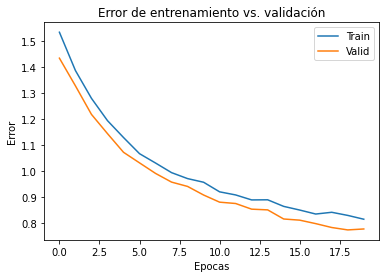

In [ ]:
plt.plot(history_inceptionv3["train_loss"])
plt.plot(history_inceptionv3["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

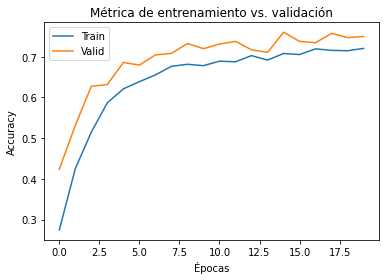

In [ ]:
plt.plot(history_inceptionv3["train_acc"])
plt.plot(history_inceptionv3["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

##GradCam sobre modelo VGG19

Dado que el modelo que mejor performace tuvo fue VGG19, utilizaremos GradCam para ver que mira el modelo en la inferencia.

### Generamos la clase para hacer gradCam con vgg19

In [ ]:
class VGG(nn.Module):
    def __init__(self,modelo,pesos):
        super(VGG, self).__init__()
        
        # Generamos el modelo y cargamos los pesos
        self.vgg = modelo
        self.vgg.load_state_dict(torch.load(pesos))   
        
        # Accedemos a la ultima capa convolucional
        self.features_conv = self.vgg.features[:36]
        
        # Obtenemos el maxPool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # Obtenemos el clasificador de vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder para los gradientes
        self.gradients = None
    
    # hook para los gradientes de las activaciones
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # Registramos el hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # Metodo para la extraccion de los gradientes
    def get_activations_gradient(self):
        return self.gradients
    
    # Metodo para la extraccion de la activacion
    def get_activations(self, x):
        return self.features_conv(x)

### Generamos el modelo base vgg19 segun lo entrenado

In [ ]:
#Transformaciones para los pesos
weights_vgg19 = VGG19_Weights.IMAGENET1K_V1
transforms_vgg19 = weights_vgg19.transforms()

#Creamos el modelo
vgg19_model = modelos.vgg19(weights=weights_vgg19)
vgg19_model.to("cuda")

# Congelamos los parametros de la red.
for param in vgg19_model.parameters():
    param.requires_grad = False

# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

vgg19_model.to("cuda")

#Buscamos los pesos pre-entrenados
model_name = '/content/drive/MyDrive/Colab Notebooks/vgg19_model.pth'



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### Aplicamos el gradCam sobre un ejemplo

#### Cargamos la imagen y la pasamos por el modelo

In [ ]:
image_path = "/content/banio2.jpg"

# Inicializamos el modelo VBB
vgg = VGG(vgg19_model,model_name)

#Cargamos la imagen a analizar
img_inferir = Image.open(image_path)
print("Imagen a analizar: ")
display(img_inferir)

#Normalizamos la imagen segun las trasnformaciones de vgg19
img_normalized = transforms_vgg19(img_inferir).float()
img_normalized = img_normalized.unsqueeze_(0)
img_normalized.requires_grad_()

#Pasamos la imagen y el modelo a GPU
if torch.cuda.is_available():
     vgg.to("cuda")
     img_normalized = img_normalized.to("cuda")

#Hacemos la prediccion
vgg.eval()
pred =vgg(img_normalized)

print("Pesos de salida del modelo: ",pred)
index = pred.data.cpu().numpy().argmax()
classes = set.classes
class_name = classes[index]
print("Clase predecida: ",class_name)

Output hidden; open in https://colab.research.google.com to view.

#### Calculamos el heatmap de la activacion

Valor de la clase  tensor([5.3020], device='cuda:0', grad_fn=<SelectBackward0>)


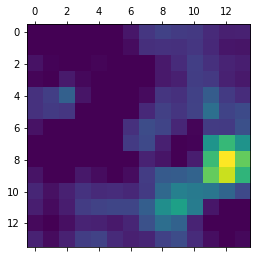

In [ ]:
#Bathroom es la clase 0, vemos el valor que le dio el modelo a la clase
print("Valor de la clase ",pred[:,0])

# Obtenemos el gradiente de la salida con respecto a los parametros del modelo
pred[:,0].backward()

# Obtengo los gradientes de la activacion
gradients = vgg.get_activations_gradient()

# Obtnemos la media de los gradientes en todos los canales
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# Obtengo las activaciones de la ultima capa convolucional
activations = vgg.get_activations(img_normalized).detach()

# Peso los canales por los gradientes
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# Obtengo la media de los canales de la activaciones
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# Normlaizamos el heatmap
heatmap /= torch.max(heatmap.cpu())

# Ploteamos el heatmap
plt.matshow(heatmap.squeeze())

#### Calculamos el heatmap de los gradientes

In [ ]:
img = cv2.imread(image_path)
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#### Mostramos la imagen con el heatmap aplicado

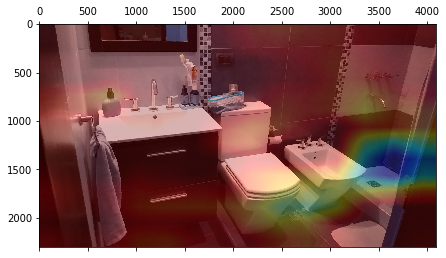

In [ ]:
superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
plt.matshow(superimposed_img)

## Análisis de resultados y conclusiones

### Diferentes modelos con transfer learning

En este caso, todos los modelos tienen aplicadas la totalidad de las transformaciones de data augmentation planteadas para este problema inicialmente. A su vez, todos son probados con transfer learning.

#### Resultados

In [ ]:
metrics_show = [ ["VGG19", best_acc_val_vgg19, test_accuracy_vgg19,'139.590.725','20.485'],
                 ["AlexNet", best_acc_val_alexnet_da, test_accuracy_alexnet_da,'57.024.325','20.485'],
                 ["ResNet50", best_acc_val_resnet50, test_accuracy_resnet50,'23.518.277','10.245'],
                 ["Inception V3", best_acc_val_inceptionv3, test_accuracy_inceptionv3,'21.795.813','10.245']]
dataframe_conclusion = pd.DataFrame(metrics_show, columns = ['Modelo','Acc Validation','Acc Test','Total Params','Trainable Params'])
print(dataframe_conclusion)

         Modelo  Acc Validation  Acc Test Total Params Trainable Params
0         VGG19        0.857334  0.806908  139.590.725           20.485
1       AlexNet        0.801950  0.737030   57.024.325           20.485
2      ResNet50        0.810761  0.776204   23.518.277           10.245
3  Inception V3        0.760259  0.704206   21.795.813           10.245


#### Conclusiones

El modelo que obtuvo la mejor métrica para este problema fue VGG19, seguido por ResNet50, AlexNet e InceptionV3.

Por otro lado, realizar transfer learning reduce considerablemente la cantidad de parámetros a entrenar. 

Por último, ResNet50 con la mitad de parámetros a entrenar aproximadamente que VGG19 (modelo ganador), se coloca inmediatamente por detrás en el ranking de la métrica.

### Modelo AlexNet con diferente tratamiento de data augmentation

En este caso, no solamente se analiza lo que pasa en la red neuronal AlexNet con y sin data augmentation, sino también se van combinando las transformaciones para analizar que va sucediendo.

Además, se aplica una transformación de escala de grises y otra de AutoAugmentation.

Todos los entrenamientos se realizan con transfer learning.

#### Resultados

In [ ]:
# Agregar pruebas intermedias.
metrics_show_2 = [["Con DA", 0.801950, 0.73703],
                 ["Sin DA", 0.813303 , 0.71198],
                 ["Solo rotaciones", 0.769561 , 0.824155],
                 ["Solo color jitter", 0.784936, 0.801612],
                 ["Solo blur gaussiano", 0.769726, 0.777613],
                 ["Rotaciones + jitter", 0.779512, 0.747537],
                 ["Rotaciones + blur gaussiano", 0.775552, 0.767155],
                 ["Color + blur gaussiano", 0.781022, 0.768727],
                 ["Escala de grises", 0.781039, 0.756872],
                 ["AutoAugmentation", 0.774802, 0.777680]]
dataframe_conclusion_2 = pd.DataFrame(metrics_show_2, columns = ['Modelo','Accuracy Validation','Accuracy Test'])
print(dataframe_conclusion_2)

                        Modelo  Accuracy Validation  Accuracy Test
0                       Con DA             0.801950       0.737030
1                       Sin DA             0.813303       0.711980
2              Solo rotaciones             0.769561       0.824155
3            Solo color jitter             0.784936       0.801612
4          Solo blur gaussiano             0.769726       0.777613
5          Rotaciones + jitter             0.779512       0.747537
6  Rotaciones + blur gaussiano             0.775552       0.767155
7       Color + blur gaussiano             0.781022       0.768727
8             Escala de grises             0.781039       0.756872
9             AutoAugmentation             0.774802       0.777680


#### Conclusiones

La primera conclusión es que aplicar una única estrategia de data augmentation permite obtener las mejores métricas de accuracy de pruebas: en este caso, rotaciones, color jitter y blur gaussiano, en ese orden. Luego, si se aplican combinaciones de a dos estrategias la métrica disminuye. Por último, disminuye aún más aplicando las tres estrategias. No obstante, no aplicar al menos una estrategia de data augmentation es la peor opción. Entonces, se observa que claramente conviene utilizar data augmentation, pero sin abusar de ésta.

Con respecto a aplicar una estrategia de escalas de grises contra una de color jitter, es mucho mejor la segunda.

Por último, AutoAugmentation se coloca en el tercer lugar, por lo tanto, entra dentro del grupo de las mejores estrategias.

### Grad-CAM

#### Resultados

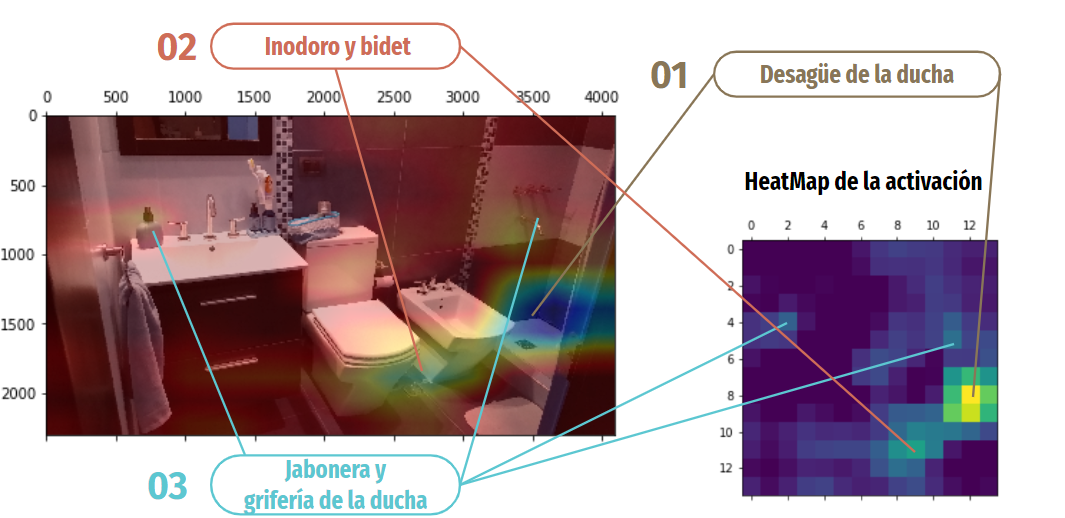

####Conclusiones

Se puede visualizar en la imagen del baño como se destacan: el desagüe de la ducha, seguido por el inodoro y el bidet, y por último, la jabonera y la grifería de la ducha. Esos son los elementos que utiliza la red para clasificar la imagen correctamente. Nótese que es muy común que éstos aparezcan en un baño.

## Links de interés

Guardar modelos:

https://pytorch.org/tutorials/beginner/saving_loading_models.html

https://discuss.pytorch.org/t/how-to-save-a-model-from-a-previous-epoch/20252

AutoAugment:

https://github.com/DeepVoltaire/AutoAugment

Inferencia:

https://stackoverflow.com/questions/60841650/how-to-test-one-single-image-in-pytorch